In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import sklearn.feature_extraction
import sklearn.model_selection
import nltk

## Exercise

Repeat last topic's example (the Reuters topic classification task) but this time try to maximise the test set performance by using all the techniques shown in this topic.
You can use the test set as a dev set for hyperparameter tuning.
All the data preprocessing and validation set extraction has been done for you.
Note that the module constructor can contain more attributes than just the parameters so you can also keep some hyperparameters there.

In [2]:
%%capture
# nltk.download('reuters')
# !unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

In [3]:
train_x = []
train_y = []
dev_x = []
dev_y = []
for file_id in nltk.corpus.reuters.fileids():
    x = ' '.join(nltk.corpus.reuters.words(file_id))
    y = nltk.corpus.reuters.categories(file_id)[0]
    if file_id.startswith('training/'):
        train_x.append(x)
        train_y.append(y)
    else:
        dev_x.append(x)
        dev_y.append(y)

(train_x, val_x, train_y, val_y) = sklearn.model_selection.train_test_split(train_x, train_y, test_size=0.1)

categories = sorted(set(train_y))

i = 0
while i < len(val_x):
    if val_y[i] in categories:
        i += 1
    else:
        val_x.pop(i)
        val_y.pop(i)

i = 0
while i < len(dev_x):
    if dev_y[i] in categories:
        i += 1
    else:
        dev_x.pop(i)
        dev_y.pop(i)

encoder = sklearn.feature_extraction.text.CountVectorizer(max_features=1000, binary=True, stop_words='english', lowercase=True, dtype=np.float32)
encoder.fit(train_x)

train_x_vecs = encoder.transform(train_x).toarray()
val_x_vecs = encoder.transform(val_x).toarray()
dev_x_vecs = encoder.transform(dev_x).toarray()

vocabulary = sorted(encoder.vocabulary_.keys(), key=encoder.vocabulary_.get)

train_y_indexes = np.array([categories.index(y) for y in train_y], np.int64)
val_y_indexes = np.array([categories.index(y) for y in val_y], np.int64)
dev_y_indexes = np.array([categories.index(y) for y in dev_y], np.int64)

In [4]:
# get number of categories
num_cat = len(categories)

In [5]:
train_x_vecs.shape

(6992, 1000)

input size = 1000, 6992 items

In [6]:
train_y_indexes.shape

(6992,)

Classification model, we need to classify a text not generate a value(regression)

In [7]:
class ExampleNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3 Layers consist of fully connected layers with dropout and leaky relu
        self.layers = torch.nn.Sequential(
          torch.nn.Linear(1000, 512),
          torch.nn.Dropout(p=0.5),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(512, 256),
          torch.nn.Dropout(p=0.5),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(256, num_cat),   
        )

    def forward(self, x):
      return self.layers(x)
      

In [8]:
# Test that the model accepts an input and outputs a tensor
model = ExampleNet()
model.eval() #means we won't train
test = model(torch.from_numpy(train_x_vecs[0]))
test

tensor([ 0.0216, -0.0420,  0.0166, -0.0262,  0.0456,  0.0142,  0.0626,  0.0312,
        -0.0811,  0.0362, -0.0290, -0.0488, -0.0296, -0.0101, -0.0241, -0.0596,
        -0.0161, -0.0215,  0.0214, -0.0018,  0.0193,  0.0072, -0.0362,  0.0648,
        -0.0200,  0.0379,  0.0439,  0.0072, -0.0203,  0.0703,  0.0479,  0.0356,
         0.0150,  0.0147, -0.0329,  0.0191, -0.0072, -0.0650,  0.0127, -0.0625,
         0.0375, -0.0546,  0.0570,  0.0536, -0.0463, -0.0030, -0.0400, -0.0187,
        -0.0503,  0.0372,  0.0063,  0.0386,  0.0330,  0.0323, -0.0317,  0.0155,
         0.0218,  0.0034,  0.0378,  0.0169, -0.0583, -0.0245, -0.0545,  0.0702,
         0.0124,  0.0198,  0.0037,  0.0020,  0.0425, -0.0041, -0.0106, -0.0233,
        -0.0373,  0.0425], grad_fn=<AddBackward0>)

a tensor with a random value for each class is outputted great !

In [9]:
# Set up dataloaders because, easy

from torch.utils.data import TensorDataset, DataLoader

train_x = torch.Tensor(train_x_vecs) # transform to torch tensor
train_y = torch.Tensor(train_y_indexes)

valid_x = torch.Tensor(val_x_vecs) # transform to torch tensor
valid_y = torch.Tensor(val_y_indexes)

dev_x = torch.Tensor(dev_x_vecs) # transform to torch tensor
dev_y = torch.Tensor(dev_y_indexes)

train_dataset = TensorDataset(train_x, train_y) # create a dataset object
valid_dataset = TensorDataset(valid_x, valid_y) # create a dataset object
dev_dataset = TensorDataset(dev_x, dev_y) # create a dataset object

train_loader = DataLoader(train_dataset, batch_size=64) # create the dataloader, this will handle batching
valid_loader = DataLoader(valid_dataset, batch_size=64) # create the dataloader, this will handle batching
dev_loader = DataLoader(dev_dataset, batch_size=64) # create the dataloader, this will handle batching


In [10]:
# Good function for classification
criterion = torch.nn.CrossEntropyLoss()
# Adam is just good
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
# setup for training & validation loop
data_loaders = {}
data_loaders['train'] = train_loader
data_loaders['val'] = valid_loader
data_lengths = {"train": train_x_vecs.shape[0], "val": val_x_vecs.shape[0]}
print(data_lengths['train'])
print(data_lengths['val'])
epochs = 20
step = epochs//5
# get the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)


6992
777
cuda


ExampleNet(
  (layers): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=74, bias=True)
  )
)

In [12]:

for epoch in range(epochs):
    if (epoch+1) % step == 0:
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for data in data_loaders[phase]:
            inputs, labels = data
            # Move data to device
            inputs, labels = inputs.to(device).float(), labels.to(device).long()
            # forward pass to get outputs
            output = model(inputs)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output.squeeze(1), labels)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()

            # print loss statistics
            running_loss += loss.item()

        epoch_loss = running_loss / data_lengths[phase]
        if (epoch+1) % step == 0:
          print('{} Loss: {:.4f}'.format(phase, epoch_loss))

Epoch 3/19
----------
train Loss: 0.0079
val Loss: 0.0118
Epoch 7/19
----------
train Loss: 0.0033
val Loss: 0.0126
Epoch 11/19
----------
train Loss: 0.0017
val Loss: 0.0126
Epoch 15/19
----------
train Loss: 0.0011
val Loss: 0.0148
Epoch 19/19
----------
train Loss: 0.0008
val Loss: 0.0147


In [13]:

# Test loop
model.train(False)  # Set model to evaluate mode
model.cpu()
predictions = []
test_labels = []
with torch.no_grad():
    for inputs, labels in dev_loader:
        inputs, labels = inputs.float(), labels.float()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for p in predicted:
            predictions.append(p)

        for l in labels:
            test_labels.append(l)



In [14]:

from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, confusion_matrix

# Print metrics
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(test_labels, predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(test_labels, predictions, beta = 0.5,average='weighted')))
print("Final precision score on the testing data: {:.4f}".format(precision_score(test_labels, predictions, average='weighted')))
print("Final recall score on the testing data: {:.4f}".format(recall_score(test_labels, predictions, average='weighted')))

Final accuracy score on the testing data: 0.8311
Final F-score on the testing data: 0.8179
Final precision score on the testing data: 0.8187
Final recall score on the testing data: 0.8311


/home/wsl/miniconda3/envs/deep_learning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Hyperparameters and their Results

---

## Starting point

```python
ExampleNet(
  (layers): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=72, bias=True)
    (7): Softmax(dim=None)
  )


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10
```
Final accuracy score on the testing data: 0.6486

Final F-score on the testing data: 0.5435

Final precision score on the testing data: 0.5262

Final recall score on the testing data: 0.6486

---

## Play with final activation function

```python
ExampleNet(
  (layers): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=72, bias=True)
  )


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10
```

##### ReLU & LogSoftmax activation function at the end achieved similar results

Final accuracy score on the testing data: 0.7786

Final F-score on the testing data: 0.7183

Final precision score on the testing data: 0.7155

Final recall score on the testing data: 0.7786

---

## Epoch

```python
ExampleNet(
  (layers): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=72, bias=True)
    (7): LogSoftmax(dim=None)
  )


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 20
```

##### epoch at 40 achieved similar results (stuck in local minima)

Final accuracy score on the testing data: 0.8265

Final F-score on the testing data: 0.7999

Final precision score on the testing data: 0.8022

Final recall score on the testing data: 0.8265

---

## Learning Rate

```python
ExampleNet(
  (layers): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=72, bias=True)
  )


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
```

Final accuracy score on the testing data: 0.8315

Final F-score on the testing data: 0.8232

Final precision score on the testing data: 0.8251

Final recall score on the testing data: 0.8315

# Visualising the results 

Visuals are important, a confusion matrix (might not be the best choice) shows the classification nicely. A bold line from the top left to the bottom right is what we want

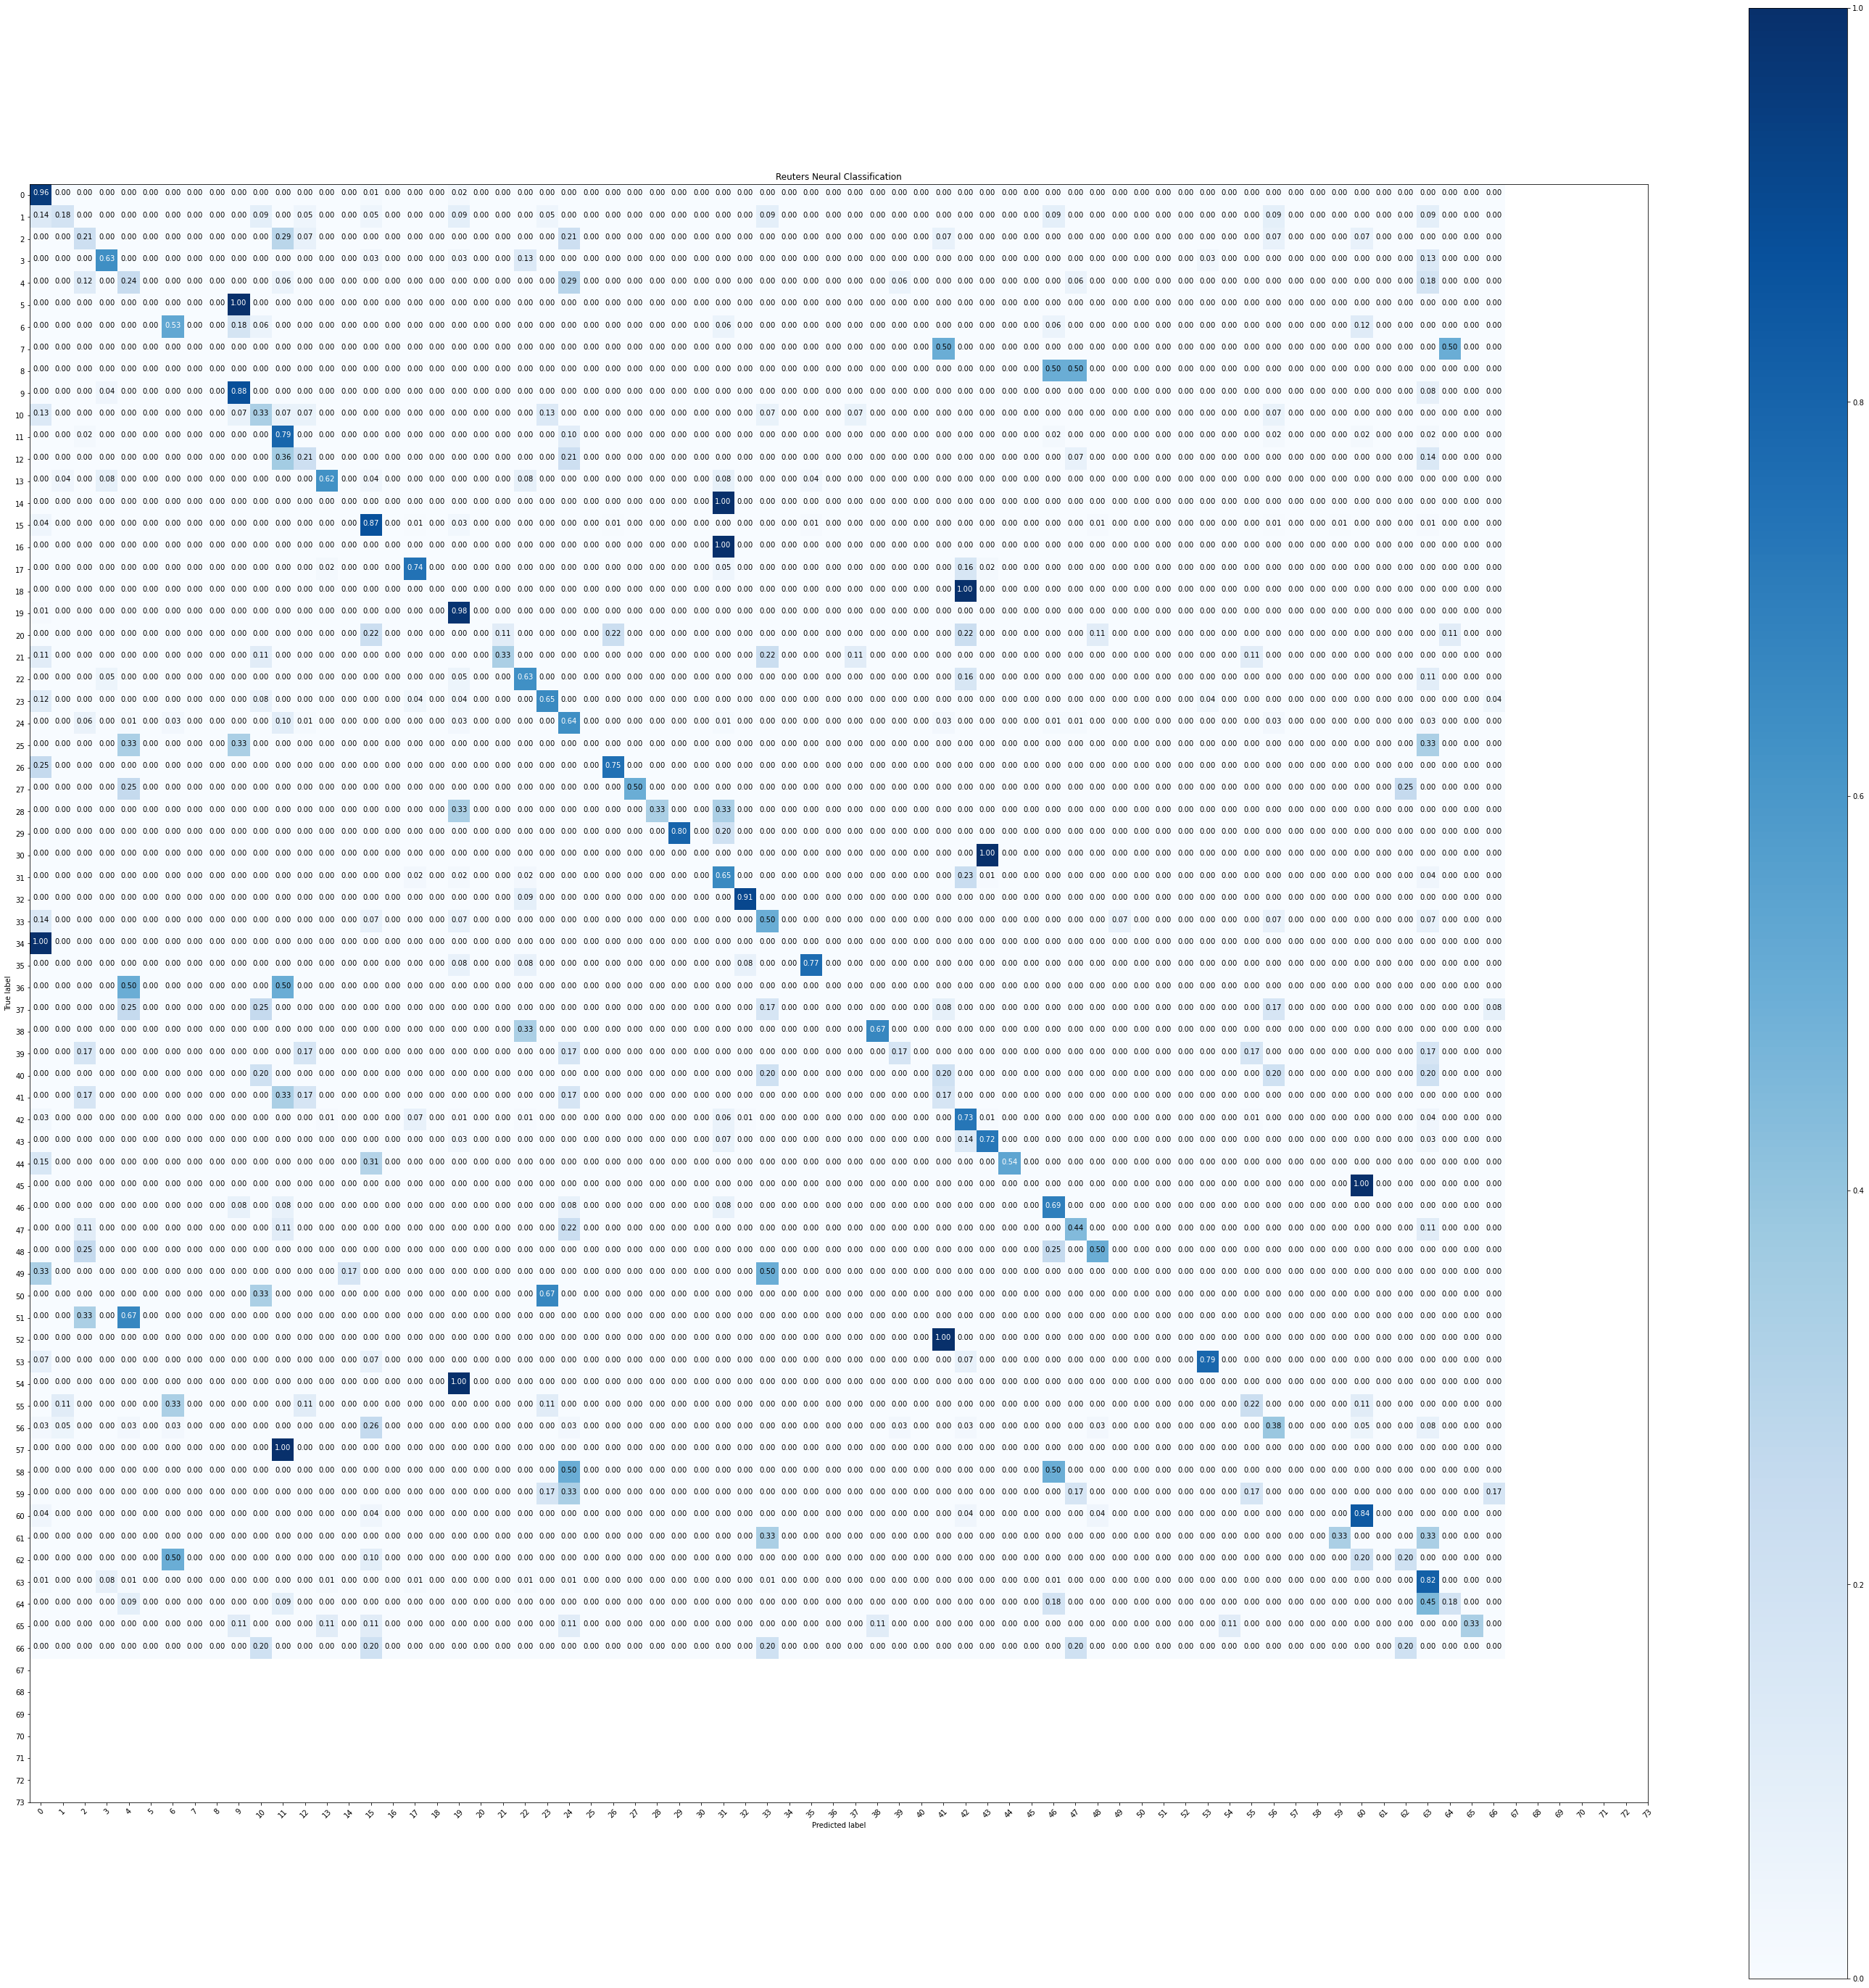

In [15]:
import itertools

# Confusion Matrix maps out the predicted label given to the data with the actual label
# Helps us check the rate of true/false positives and true/false negatives
# parameters are the true labels, and the predicted labels

plt.rcParams['figure.figsize'] = [50, 50]
# https://sklearn.org/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title + '.png')



cnf_matrix = confusion_matrix(test_labels, predictions)
np.set_printoptions(precision=2)

classes = {x:x for x in range(num_cat)}

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Reuters Neural Classification')